### Import required libraries

In [1]:
from traffic.core import Traffic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Preparation on trajectory level

In [2]:
# Load data, assign unique flight IDs, resample to 5s
trajs = Traffic.from_file('data/rectangle_1/02_combined/combined.parquet')
trajs_filt = trajs.assign_id().resample('5s').eval(desc='processing', max_workers=20)
# Aggregate by flight, determine stay time and hour of entry
df = trajs_filt.data
df = df.groupby('flight_id')['timestamp'].agg(['min', 'max']).reset_index()
df = df.rename({'min': 'in', 'max': 'out'}, axis=1)
df['flight_hours'] = (df['out'] - df['in']).dt.total_seconds() / 3600
df['timestamp_entered_h'] = df['in'].dt.floor('h')
df = df.drop(['in','out'], axis=1)
df

Output()

/cluster/home/krum/miniconda3/envs/vt_2_env/lib/python3.11/site-packages/traffic/core/lazy.py:231: TqdmExperimentalWarning: rich is experimental/alpha
  tasks_completed = tqdm(


,flight_id,flight_hours,timestamp_entered_h
0,00000000_8255,0.015278,2020-02-18 13:00:00+00:00
1,0000000_75305,0.015278,2018-06-05 11:00:00+00:00
2,08V W40_19960,0.016667,2018-03-04 09:00:00+00:00
3,2 F9_66776,0.001389,2018-01-07 09:00:00+00:00
4,20_104,0.001389,2021-09-24 12:00:00+00:00
...,...,...,...
80755,Z U R 9_4365,0.020833,2018-01-19 06:00:00+00:00
80756,Z3MKD_75356,0.008333,2022-05-25 13:00:00+00:00
80757,Z7 4 MC_66595,0.000000,2018-03-04 20:00:00+00:00
80758,ZHM G_4521,0.000000,2018-05-03 19:00:00+00:00


### Reduce to 2018 and 2019

In [3]:
years = [2018, 2019]

# only keep flights that entered in 2018 or 2019
df20189 = df[df['timestamp_entered_h'].dt.year.isin(years)]

### Group data by hour

In [4]:
# Aggregate by hour of entry, determine number of users and total stay time
hourly_stay = df20189.groupby(['timestamp_entered_h'])['flight_hours'].sum()
hourly_users = df20189.groupby(['timestamp_entered_h'])['flight_id'].count()
hourly_df = pd.concat([hourly_users, hourly_stay], axis=1)#.reset_index()
hourly_df = hourly_df.rename({'flight_id': 'count'}, axis=1)
hourly_df['year'] = hourly_df.index.year
hourly_df['month'] = hourly_df.index.month
hourly_df['day_of_year'] = hourly_df.index.day_of_year
hourly_df['day_of_month'] = hourly_df.index.day
hourly_df['hour'] = hourly_df.index.hour
hourly_df['weekday'] = hourly_df.index.weekday
hourly_df['day_name'] = hourly_df.index.day_name()
hourly_df['week_of_year'] = hourly_df.index.week
hourly_df

/tmp/ipykernel_31118/1978648726.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  hourly_df['week_of_year'] = hourly_df.index.week


,count,flight_hours,year,month,day_of_year,day_of_month,hour,weekday,day_name,week_of_year
timestamp_entered_h,,,,,,,,,,
2018-01-01 06:00:00+00:00,3,0.048611,2018,1,1,1,6,0,Monday,1
2018-01-01 07:00:00+00:00,3,0.058333,2018,1,1,1,7,0,Monday,1
2018-01-01 08:00:00+00:00,1,0.018056,2018,1,1,1,8,0,Monday,1
2018-01-01 09:00:00+00:00,3,0.063889,2018,1,1,1,9,0,Monday,1
2018-01-01 10:00:00+00:00,3,0.030556,2018,1,1,1,10,0,Monday,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00+00:00,2,0.018056,2019,12,365,31,15,1,Tuesday,1
2019-12-31 16:00:00+00:00,3,0.065278,2019,12,365,31,16,1,Tuesday,1
2019-12-31 18:00:00+00:00,2,0.037500,2019,12,365,31,18,1,Tuesday,1


### Remove outliers

In [ ]:
# df_no_out = hourly_df[hourly_df['flight_hours'] < hourly_df['flight_hours'].quantile(0.99)]
# # plot flight hours over time
# sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='flight_hours')

# plt.gcf().set_size_inches(20, 10)
# plt.show()

### Trend

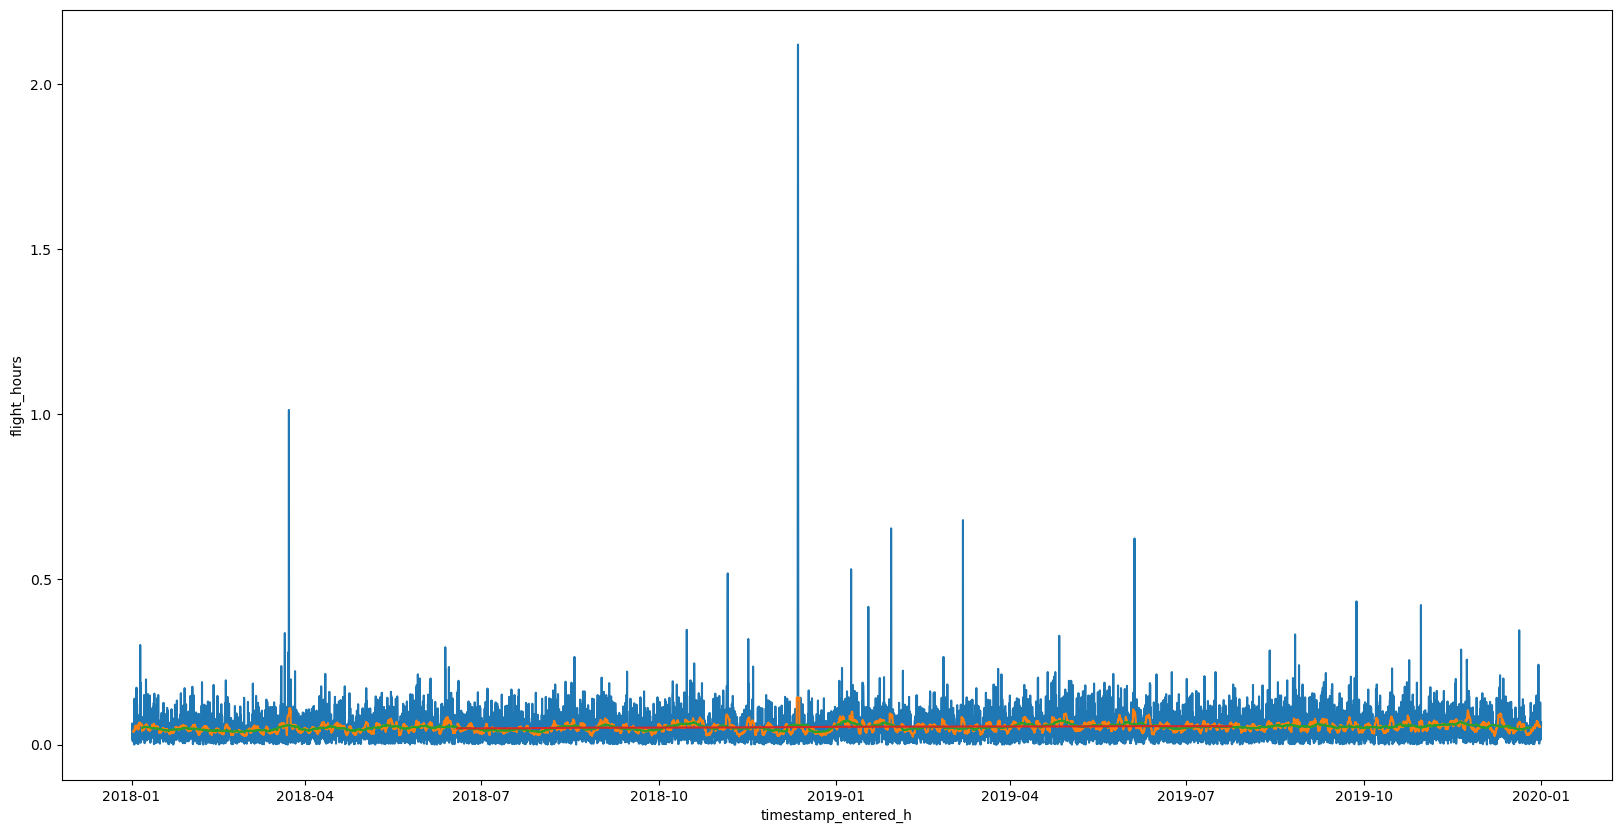

In [5]:
df_no_out = hourly_df

df_no_out['daily_smoothed'] = df_no_out['flight_hours'].rolling(24, center=True).mean()
df_no_out['weekly_smoothed'] = df_no_out['flight_hours'].rolling(24*7, center=True).mean()
df_no_out['monthly_smoothed'] = df_no_out['flight_hours'].rolling(24*7*30, center=True).mean()

sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='flight_hours')
sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='daily_smoothed')
sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='weekly_smoothed')
sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='monthly_smoothed')

plt.gcf().set_size_inches(20, 10)
plt.show()

In [ ]:
df_no_out['trend_removed'] = df_no_out['flight_hours']-df_no_out['daily_smoothed']

sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='trend_removed')
# sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='daily_smoothed')

plt.gcf().set_size_inches(20, 10)
plt.show()

In [ ]:
# average flight hours per hour of day

# scatterplot hour on the x axis and flight hours on the y axis. light gray and transparent
sns.lineplot(data=df_no_out, x='hour', y='flight_hours', alpha=0.1, color='lightgray', units="day_of_year", errorbar=None, estimator=None)
sns.catplot(data=df_no_out, x='hour', y='flight_hours', kind='box', color='lightgray', showfliers=False)
sns.lineplot(data=df_no_out, x='hour', y='flight_hours', estimator='mean', color='red', errorbar=None)

plt.gcf().set_size_inches(20, 10)
plt.show()

In [ ]:
# average flight hours per hour of day

# scatterplot hour on the x axis and flight hours on the y axis. light gray and transparent
# sns.lineplot(data=df_no_out, x='day_name', y='flight_hours', alpha=0.1, color='lightgray')
sns.lineplot(data=df_no_out, x='day_name', y='flight_hours', alpha=0.1, color='lightgray', units="day_of_year", errorbar=None, estimator=None)
sns.lineplot(data=df_no_out, x='day_name', y='flight_hours', estimator='mean', color='red', errorbar=None)

plt.gcf().set_size_inches(20, 10)
plt.show()

In [ ]:
sns.lineplot(data=df_no_out, x='month', y='flight_hours', estimator='mean', color='red', errorbar=None)

plt.gcf().set_size_inches(20, 10)
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import STL
res = STL(df_no_out.flight_hours).fit()

In [ ]:
df_no_out

In [ ]:
type(df_no_out.index[0])

In [ ]:
# determine trend of flight hours over time
df_no_out['flight_hours'].diff().rolling(500, center=True).mean().plot()

In [ ]:
df_no_out

In [ ]:
from statsmodels.tsa.seasonal import MSTL

mstl = MSTL(df_no_out['flight_hours'], periods=[24, 24 * 7, 24 * 30])
res = mstl.fit()
fig = res.plot()
fig.set_size_inches(20, 10)
plt.show()

In [ ]:
# apply stl to data
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import STL
stl = STL(df_no_out['flight_hours'], period=24)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 10)
plt.show()

In [ ]:
# df_use = hourly_df.reset_index()
# df_use = df_use.rename({'timestamp_entered_h': 'timestamp'}, axis=1)
# # add columns containing the hour of the day, the day of the week, the week of the year, and the month
# df_use['hour'] = df_use['timestamp'].dt.hour
# df_use['day'] = df_use['timestamp'].dt.dayofweek
# df_use['day_name'] = df_use['timestamp'].dt.day_name()
# df_use['week'] = df_use['timestamp'].dt.week
# df_use['month'] = df_use['timestamp'].dt.month
# df_use

### Get rid of outliers

In [ ]:
# remove rows containing the highhest one percent of the stay time
df_use = df_use[df_use['stay_s'] < df_use['stay_s'].quantile(0.99)]
df_use

In [ ]:
ax = sns.boxplot(x="hour", y="stay_s", data=df_use, showfliers=False)

In [ ]:
plt.figure(figsize=(15,4), dpi=100)
plt.plot(, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()

In [ ]:
df_hour = df_no_out['stay_s']
df_2019 = df_hour.reset_index()
df_2019 = df_2019.rename({'timestamp_entered_h': 'timestamp'}, axis=1)
df_2019

In [ ]:
df_hour = hourly_df['stay_s']

f, ax = plt.subplots(figsize=(18,20),dpi=200);
plt.suptitle('American Electric Power (AEP) estimated energy consumption in MegaWatts (MW)', fontsize=24);
df_hour.plot(ax=ax,rot=90,ylabel='MW');

In [ ]:
import statsmodels.api as sm
import numpy as np

#extracting daily seasonality from raw time series
sd_24 = sm.tsa.seasonal_decompose(df_hour, period=24)

# #extracting weekly seasonality from time series adjusted by daily seasonality
# sd_168 = sm.tsa.seasonal_decompose(df_hour - np.array(sd_24.seasonal).reshape(-1,1), period=168)

# #extracting yearly seasonality from time series adjusted by daily and weekly seasonality
# sd_8766 = sm.tsa.seasonal_decompose(df_hour - np.array(sd_168.seasonal).reshape(-1,1), period=8766)

In [ ]:
from statsmodels.tsa.seasonal import MSTL

mstl = MSTL(df_no_out["stay_s"], periods=(12, 24, 24 * 7), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()
# define a figure with a custom size
plt.rc("figure", figsize=(20,20))
res.plot()

In [ ]:
res.seasonal

In [ ]:
import statsmodels.api as sm

daily_components = sm.tsa.seasonal_decompose(df_hour, period=24)
weekly_components= sm.tsa.seasonal_decompose(df_hour, period=24*7)

# adjusted = df_hour["stay_s"] - daily_components.seasonal - weekly_components.seasonal

In [ ]:
adjusted = df_hour - daily_components.seasonal - weekly_components.seasonal

In [ ]:
sm.tsa.seasonal_decompose(df_hour, period=7).plot()

In [ ]:
mean = 
df_no_out['weekly_smoothed'] = df_no_out['flight_hours'].rolling(24*7, center=True).mean()
df_no_out['monthly_smoothed'] = df_no_out['flight_hours'].rolling(24*7*30, center=True).mean()

sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='flight_hours')
sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='daily_smoothed')
sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='weekly_smoothed')
sns.lineplot(data=df_no_out, x='timestamp_entered_h', y='monthly_smoothed')

plt.gcf().set_size_inches(20, 10)
plt.show()